In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random

from tqdm import tqdm_notebook
from skimage.io import imread, imshow
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable
import cv2

from pathlib import Path

## Get paths for images and sort them

In [2]:

path = 'data/DRIVE/'
path_test = 'test/images_gray'
path_test_mask = 'test/1st_manual'
path_train = 'training/images_gray'
path_train_c = 'training/images_clahe'
path_train_g = 'training/images_gamma'
path_train_mask = 'training/manual'

img_path = Path(os.path.join(path, path_train))
img_path_c = Path(os.path.join(path, path_train_c))
img_path_g = Path(os.path.join(path, path_train_g))
mask_path = Path(os.path.join(path, path_train_mask))
test_img_path = Path(os.path.join(path, path_test))
test_mask_path = Path(os.path.join(path, path_test_mask))

#sort images to line up train and mask
img_names = []
img_names_c = []
img_names_g = []
mask_names = []
test_img_names = []
test_mask_names = []
for img, img_c, img_g, mas, test_img in zip(img_path.iterdir(),
                                     img_path_c.iterdir(),
                                     img_path_g.iterdir(),
                                     mask_path.iterdir(),
                                     test_img_path.iterdir()):
    img_names.append(str(img))
    img_names_c.append(str(img_c))
    img_names_g.append(str(img_g))
    mask_names.append(str(mas))
    test_img_names.append(str(test_img))
    #test_mask_names.append(str(test_mask))
    
mask_names.sort()
img_names.sort()
img_names_c.sort()
img_names_g.sort()
test_img_names.sort()
#test_mask_names.sort()

In [3]:
len(test_img_names)

20

(584, 565)
(584, 565)


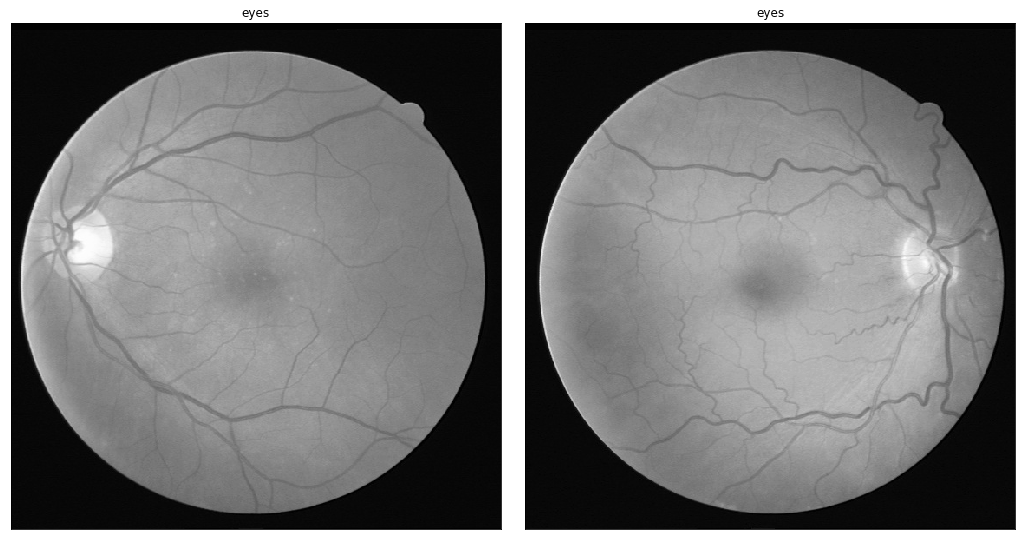

(584, 565)
(584, 565)


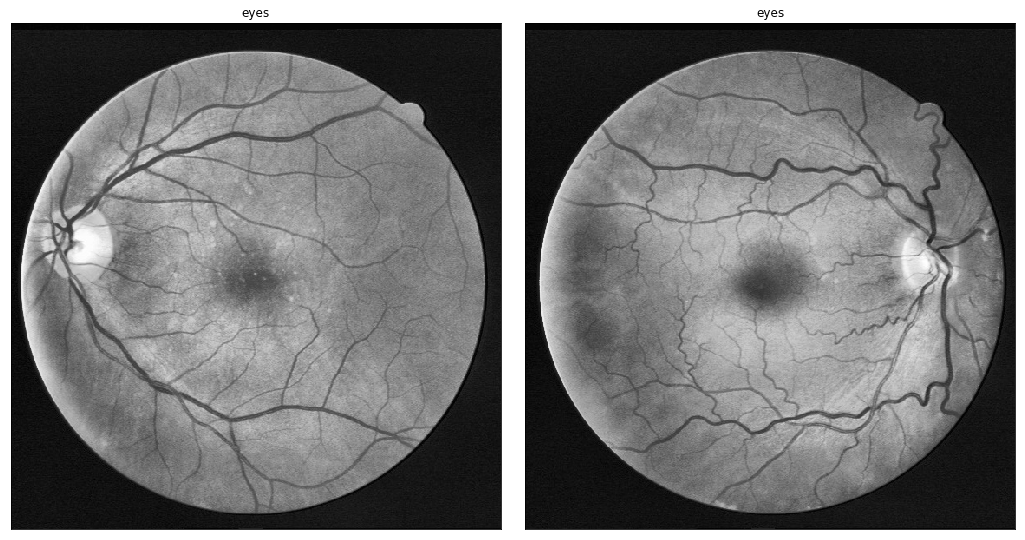

(584, 565)
(584, 565)


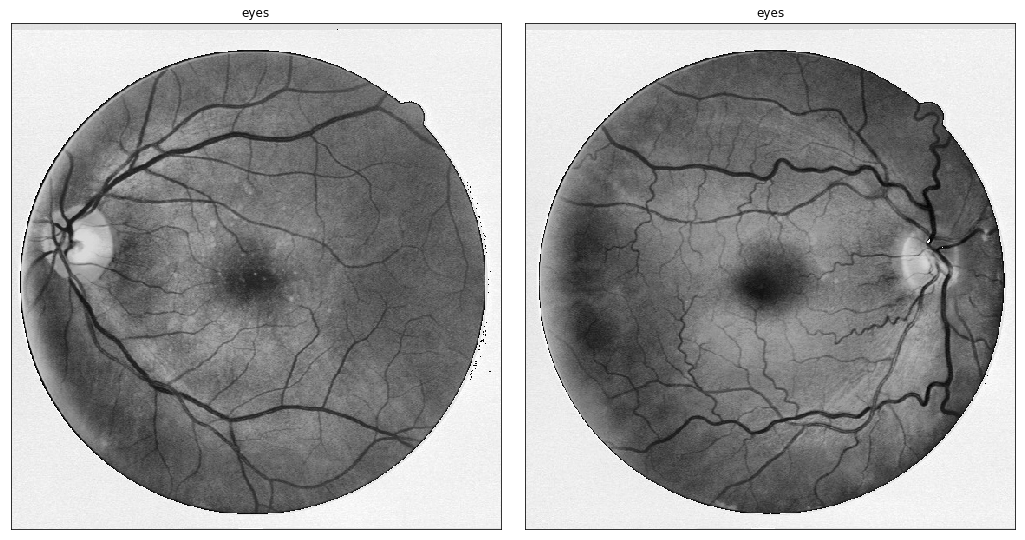

(584, 565)
(584, 565)


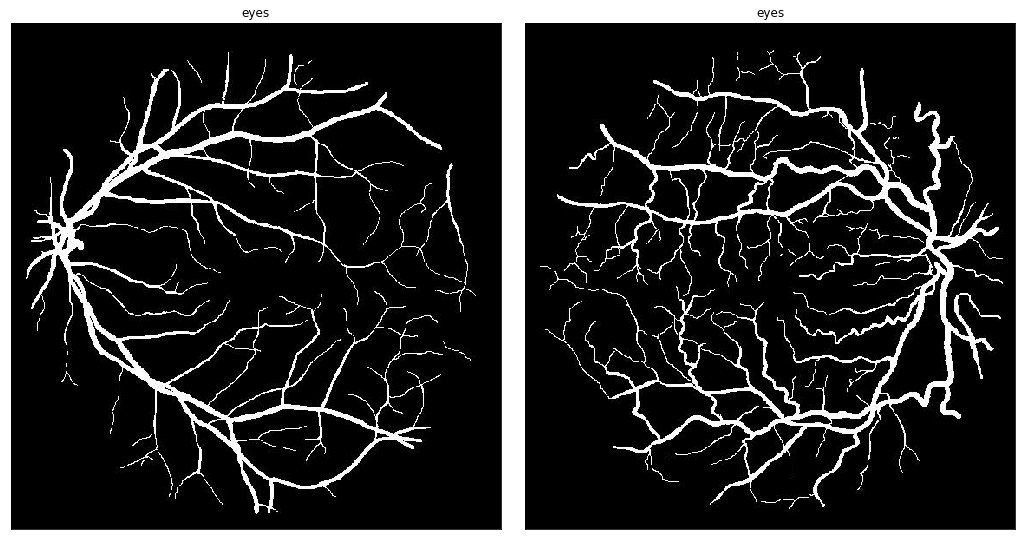

In [4]:
##show first two images 
def showImg(p):
    fig, axes = plt.subplots(1, 2, figsize=(18,18),
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax, i in zip(axes.flat, range(2)):
        img = imread(p[i])
        ax.imshow(img, cmap='gray')
        ax.set_title('eyes')  
        print(img.shape)
    plt.show()


# fig = plt.figure(figsize=(10,10))
# ax1 = fig.add_subplot(111)
# ax1.imshow(cl1, cmap='gray')
# plt.show()
    
showImg(img_names)
showImg(img_names_c)
showImg(img_names_g)
showImg(mask_names)


### Resize and flip images

In [5]:
im_width = 560
im_height = 560
im_chan = 3
X_train = np.zeros((len(img_names)*9, im_height, im_width, 1), dtype=np.uint8)
Y_train = np.zeros((len(img_names)*9, im_height, im_width, 1), dtype=np.bool_)
X_test = np.zeros((len(img_names), im_height, im_width, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ... ')

counter = 0
for i in tqdm_notebook(range(len(img_names))):
    img = imread(img_names[i])
    #[20:580,4:564]
    img = img[20:580,4:564]
    img = np.expand_dims(img, axis=2)
#     x = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[counter] = img
     
    mask = imread(mask_names[i])
    mask = mask[20:580,4:564]
    m_ = np.zeros_like(mask)
    for k in range(560):
        for j in range(560):
            if mask[k][j]>30 :
                m_[k][j] = 1
    m_ = np.expand_dims(m_, axis=2)
    
    #mask = resize(m_, (im_height, im_width, 1), mode='constant', preserve_range=True) 
    Y_train[counter] = m_    
    counter += 1
    
    #mod image and mask together
    X_train[counter] = np.fliplr(img)
    Y_train[counter] = np.fliplr(m_)
    
    counter +=1
    
    X_train[counter] = np.flipud(img)
    Y_train[counter] = np.flipud(m_)    
    counter +=1
    
    img = imread(img_names_c[i])
    #[20:580,4:564]
    img = img[20:580,4:564]
    img = np.expand_dims(img, axis=2)
#     x = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[counter] = img
    Y_train[counter] = m_
    counter +=1
    
    img = imread(img_names_g[i])
    #[20:580,4:564]
    img = img[20:580,4:564]
    img = np.expand_dims(img, axis=2)
#     x = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[counter] = img
    Y_train[counter] = m_
    counter +=1
    
    X_train[counter] = np.rot90(img)
    Y_train[counter] = np.rot90(m_)    
    counter +=1
    
    
    img = imread(img_names[i])
    x = resize(img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    X_train[counter] = x
     
    mask = imread(mask_names[i])
    m_ = np.zeros_like(mask)
    for k in range(584):
        for j in range(564):
            if mask[k][j]>50 :
                m_[k][j] = 1
    
    mask = resize(m_, (im_height, im_width, 1), mode='constant', preserve_range=True) 
    Y_train[counter] = mask    
    counter += 1
    
    
    X_train[counter] = np.rot90(x)
    Y_train[counter] = np.rot90(mask)    
    counter +=1
       
    X_train[counter] = np.fliplr(x)
    Y_train[counter] = np.fliplr(mask)    
    counter +=1
    
    
    #resize for test images
    test_img = imread(test_img_names[i])
    test_img = test_img[20:580,4:564]
    #test_img = resize(test_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
    test_img = np.expand_dims(test_img, axis=2)
    X_test[i] = test_img
   
print('Done!')

Getting and resizing train images and masks ... 


/home/tony/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


In [6]:
X_train.shape

(180, 560, 560, 1)

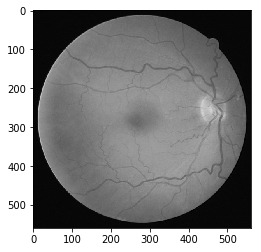

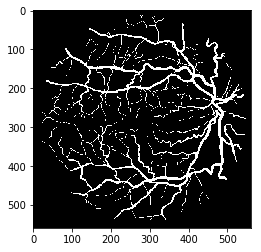

In [7]:
#resized images
ix = 9
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

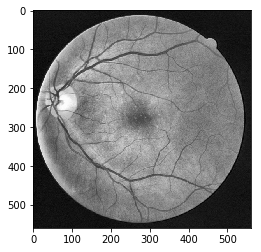

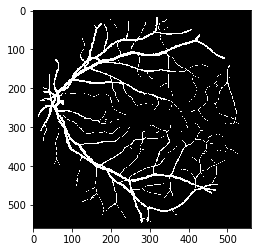

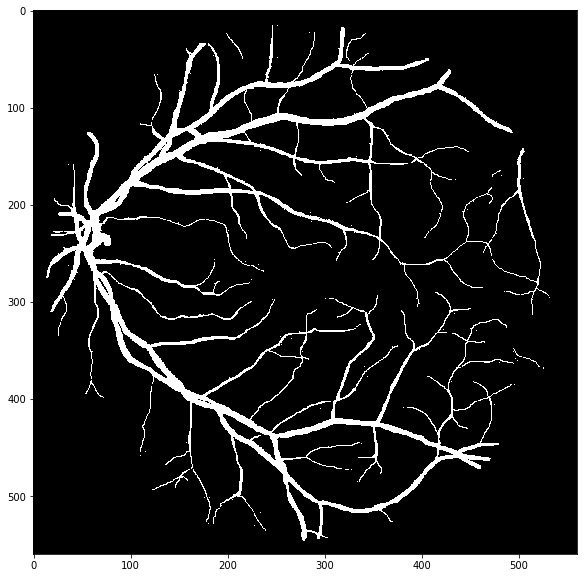

In [8]:
#resized images
ix = 3
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
# cl1 = clahe.apply(np.dstack((tmp,tmp,tmp)))

# plt.imshow(cl1, cmap='gray')
# plt.show()

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

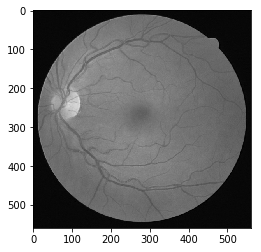

In [9]:
#resized images
ix = 0
plt.imshow(np.dstack((X_test[ix],X_test[ix],X_test[ix])))
plt.show()

### Create dataset

In [10]:
class eye_dataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images, train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
            return (image, mask)
        return image

In [11]:
X_train[0].shape

(560, 560, 1)

In [12]:
#reshape
X_train_shaped = X_train.reshape(-1, 1, 560, 560)/255
Y_train_shaped = Y_train.reshape(-1, 1, 560, 560)

X_test_shaped = X_test.reshape(-1,1, 560, 560)/255

In [13]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

X_test_shaped = X_test_shaped.astype(np.float32)

In [14]:
X_train_shaped[0].shape

(1, 560, 560)

In [15]:
X_test_shaped[0].shape

(1, 560, 560)

In [16]:
#split
idx = list(range(180))
train_idxs = idx[:135]
val_idxs = idx[135:]

In [17]:
# val_idxs

In [18]:
eye_dataset_train = eye_dataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])

eye_dataset_val = eye_dataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

eye_test_dataset = eye_dataset(X_test_shaped[:2], train=False)

batch_size = 1

train_loader = torch.utils.data.DataLoader(dataset=eye_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=eye_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=eye_test_dataset, batch_size=1,
                                         shuffle=False)

In [102]:


def conv3x3(in_channels, out_channels, stride=1, dilation=1, padding=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=padding, bias=False, dilation=dilation)
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, 
                 dilation=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride, dilation, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, dilation, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet Module
class ResNet(nn.Module):
    def __init__(self, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(16, layers[0], 1,1)
        self.layer2 = self.make_layer(32, layers[0], 1,2,2)
        self.layer3 = self.make_layer(64, layers[1], 1,4,4)
        #self.avg_pool = nn.AvgPool2d(8)
        #self.fc = nn.Linear(64, num_classes)
        self.convL = conv3x3(64,1)

    def make_layer(self, out_channels, blocks, stride=1, dilation=1, padding=1):
        downsample = None
        if (padding != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride,dilation=dilation, padding = padding),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))   # Major change here
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))    # Major change here
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.avg_pool(out)
        #out = out.view(out.size(0), -1)
        #out = self.fc(out)
        out = self.convL(out)
        return out

#resnet = ResNet([3, 3, 3])

In [103]:
model = ResNet([3, 3, 3])
model.cuda()

# state_dict = torch.load('data/eyeResults/res_unetAgam_c160_4.pth')
# model.load_state_dict(state_dict)

criterion = nn.BCEWithLogitsLoss()

learning_rate = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', 
#                                                        factor=0.1, 
#                                                        patience=8,
#                                                        threshold=.000001, 
#                                                        verbose=True)


In [106]:
mean_train_losses = []
mean_val_losses = []
minLoss = 9999
for epoch in range(200):
    train_losses = []
    val_losses = []
    for images, masks in train_loader:        
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)        
        
        loss = criterion(outputs, masks)
        train_losses.append(loss.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    for images, masks in val_loader:
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_losses.append(loss.data)
    
    
    mean_train_losses.append(np.mean(train_losses))
    mean_val_losses.append(np.mean(val_losses))
#     scheduler.step(mean_val_losses[epoch])
    
    # Print Loss
    print('Epoch: {}. Train Loss: {}. Val Loss: {}'.format(epoch+1, np.mean(train_losses), np.mean(val_losses)))
    if np.mean(val_losses) < minLoss:
        torch.save(model.state_dict(), 'data/eyeResults/res_dilAgam_c180_2.pth' )
        print(f'NEW BEST: {np.mean(val_losses)} ........old best:{minLoss}')
        minLoss = np.mean(val_losses)
        
    else:
        print('Val Loss did not improve')
 
torch.save(model.state_dict(), 'data/eyeResults/res_dil_c180Agam_2_f.pth' )

Epoch: 1. Train Loss: 0.12451548874378204. Val Loss: 0.11020690947771072
NEW BEST: 0.11020690947771072 ........old best:9999
Epoch: 2. Train Loss: 0.12308517843484879. Val Loss: 0.11015505343675613
NEW BEST: 0.11015505343675613 ........old best:0.11020690947771072
Epoch: 3. Train Loss: 0.12053372710943222. Val Loss: 0.11091972142457962
Val Loss did not improve
Epoch: 4. Train Loss: 0.1185077354311943. Val Loss: 0.10790231823921204
NEW BEST: 0.10790231823921204 ........old best:0.11015505343675613
Epoch: 5. Train Loss: 0.11819455027580261. Val Loss: 0.10592897236347198
NEW BEST: 0.10592897236347198 ........old best:0.10790231823921204
Epoch: 6. Train Loss: 0.11605018377304077. Val Loss: 0.11235471069812775
Val Loss did not improve
Epoch: 7. Train Loss: 0.1190013587474823. Val Loss: 0.10806471854448318
Val Loss did not improve
Epoch: 8. Train Loss: 0.11630694568157196. Val Loss: 0.1067918911576271
Val Loss did not improve
Epoch: 9. Train Loss: 0.11436843127012253. Val Loss: 0.10396530479

Epoch: 77. Train Loss: 0.10110511630773544. Val Loss: 0.09369920939207077
Val Loss did not improve
Epoch: 78. Train Loss: 0.09865212440490723. Val Loss: 0.0938182845711708
Val Loss did not improve
Epoch: 79. Train Loss: 0.10043559968471527. Val Loss: 0.09528133273124695
Val Loss did not improve
Epoch: 80. Train Loss: 0.11732707917690277. Val Loss: 0.09922077506780624
Val Loss did not improve
Epoch: 81. Train Loss: 0.10260748863220215. Val Loss: 0.0991891622543335
Val Loss did not improve
Epoch: 82. Train Loss: 0.10148406028747559. Val Loss: 0.10811806470155716
Val Loss did not improve
Epoch: 83. Train Loss: 0.10214784741401672. Val Loss: 0.0959116742014885
Val Loss did not improve
Epoch: 84. Train Loss: 0.09830709546804428. Val Loss: 0.09583137184381485
Val Loss did not improve
Epoch: 85. Train Loss: 0.09879936277866364. Val Loss: 0.09347965568304062
Val Loss did not improve
Epoch: 86. Train Loss: 0.10012401640415192. Val Loss: 0.09306178987026215
Val Loss did not improve
Epoch: 87. Tr

KeyboardInterrupt: 

In [ ]:
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train")
val_loss_series.plot(label="validation")
plt.legend()


In [ ]:
model = Res_Block()
model.cuda()
state_dict = torch.load('data/eyeResults/res_dilAgam_c180_2.pth')
model.load_state_dict(state_dict)
model.eval()

In [ ]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    #image = image.unsqueeze(0)
    y_pred = model(image)
    res.append(y_pred)



In [ ]:
def res_show(img):
    result = img.reshape(560,560,-1)
    result = result.data.cpu().numpy()
    result = np.squeeze(result).astype(np.float32)
#     x = resize(result, (584, 565, 1), mode='constant', preserve_range=True)
#     x = np.squeeze(x).astype(np.float32)
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    ax1.imshow(np.dstack((result,result,result)))
    plt.show()
#res_show(res[0][0])



In [ ]:
res_show(res[0][0])

In [ ]:
res_show(res[1][0])

In [ ]:
res_show(res[0][0])

In [ ]:
res_show(res[1][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


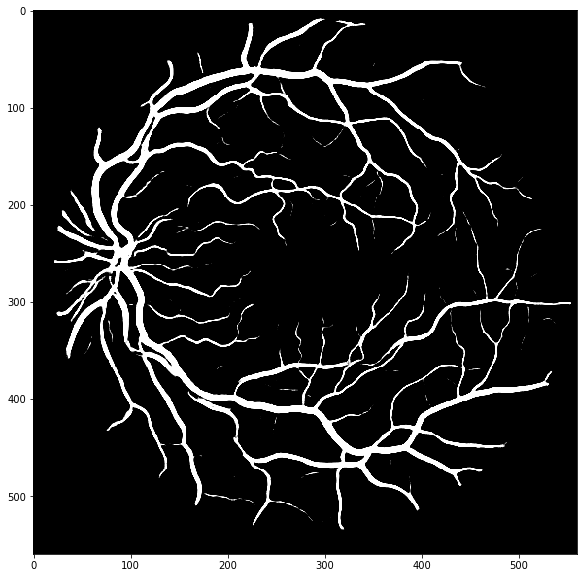

In [29]:
res_show(res[2][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


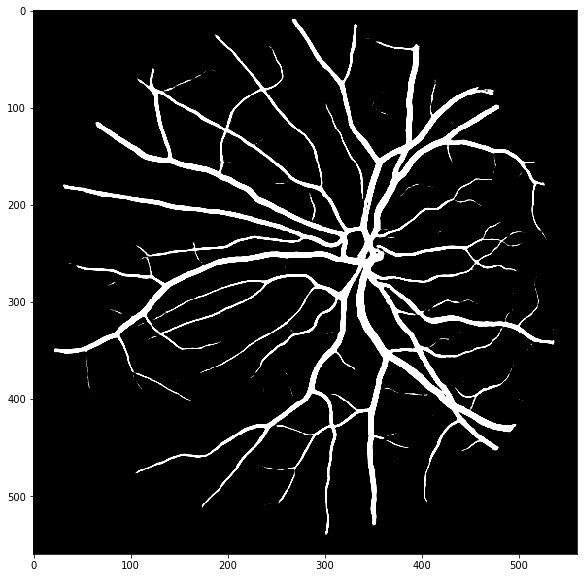

In [30]:
res_show(res[3][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


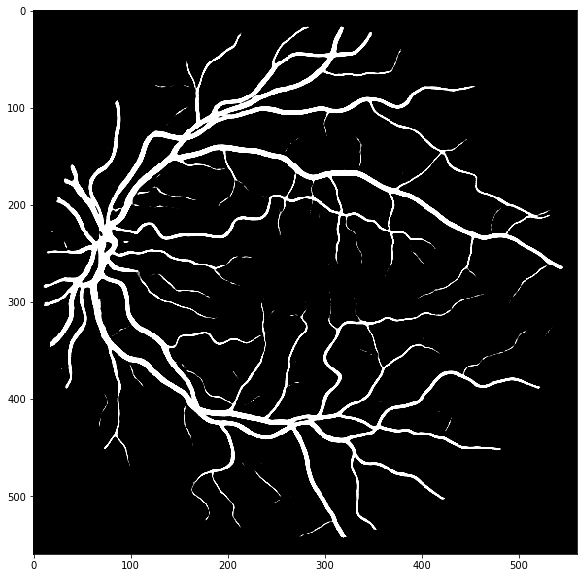

In [31]:
res_show(res[4][0])

In [33]:
eye_test_dataset = eye_dataset(X_test_shaped[7:14], train=False)

test_loader = torch.utils.data.DataLoader(dataset=eye_test_dataset, batch_size=1,
                                         shuffle=False)

In [34]:
res = []
for im in test_loader:
    image = Variable(im.type(torch.FloatTensor).cuda())
    #image = image.unsqueeze(0)
    y_pred = model(image)
    res.append(y_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


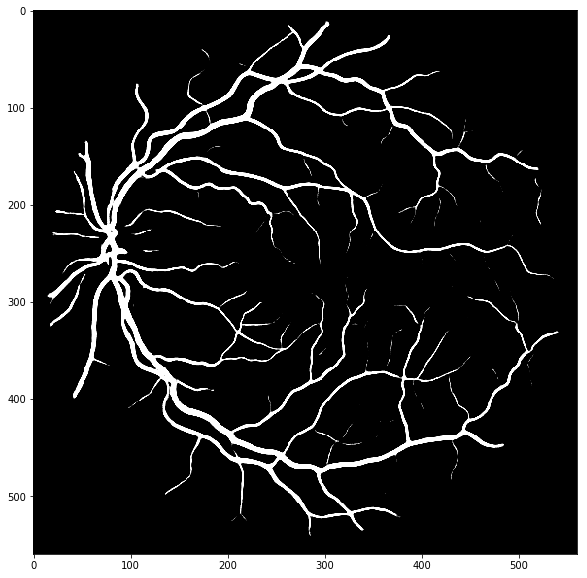

In [35]:
res_show(res[1][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


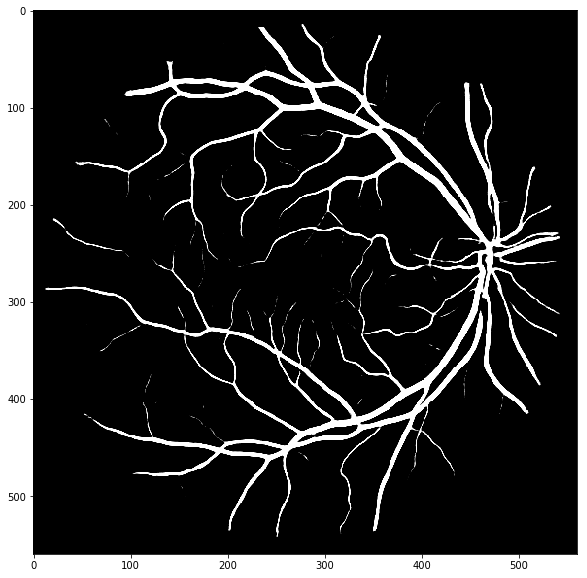

In [36]:
res_show(res[2][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


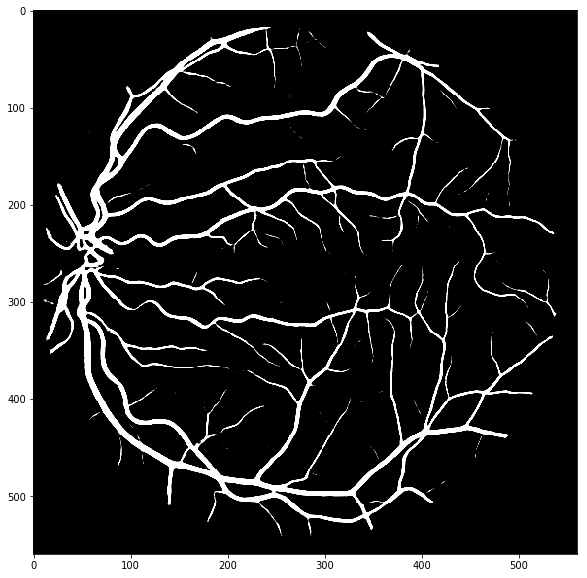

In [37]:
res_show(res[3][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


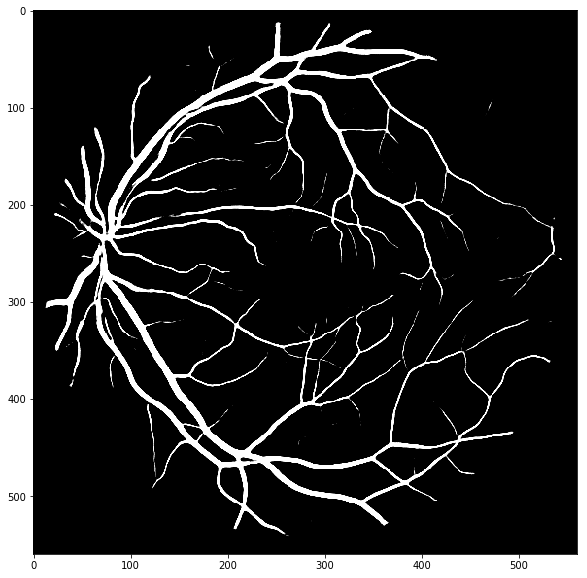

In [38]:
res_show(res[4][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


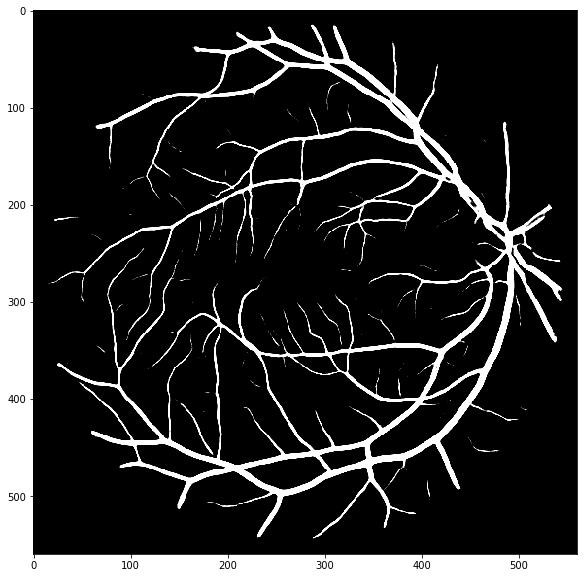

In [39]:
res_show(res[5][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


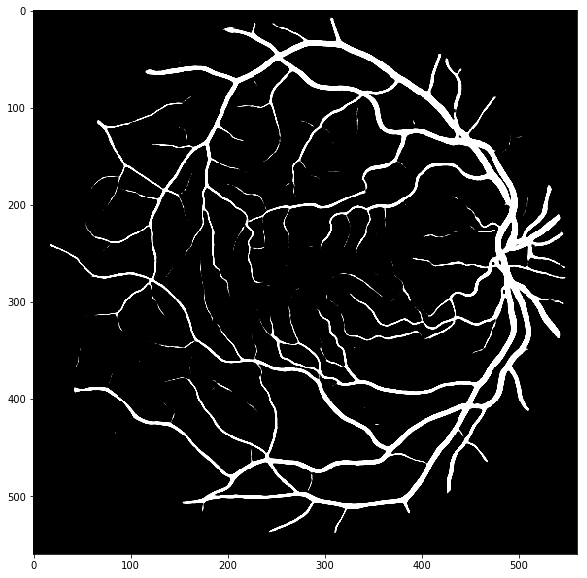

In [40]:
res_show(res[6][0])